In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def smooth(track, window_size):
    """
    Smooth out time series using a simple moving average.
    
    Parameters:
        pnl (list or Series): List or Series containing P&L data.
        window_size (int): Size of the moving average window.
        
    Returns:
        smoothed_pnl (Series): Smoothed P&L using moving average.
    """
    track_series = pd.Series(track)
    smoothed_track = track_series.rolling(window=window_size).mean()
    return smoothed_track

def kelly(decimal_odds, P, fractional):
    # shrinkage is the percent we want to shrink bets to account for uncertanity
    B = decimal_odds - 1
    Q = 1 - P
    solution = (B*P - Q) / B
    solution = solution * fractional
    return solution

# def remove_outliers(pnl, threshold=3):
#     """
#     Remove outliers from P&L data using z-score.
    
#     Parameters:
#         pnl (list or Series): List or Series containing P&L data.
#         threshold (float): Threshold value for z-score. Default is 3.
        
#     Returns:
#         cleaned_pnl (list or Series): P&L data with outliers removed.
#     """
#     pnl_array = np.array(pnl)
#     z_scores = np.abs((pnl_array - np.mean(pnl_array)) / np.std(pnl_array))
#     cleaned_pnl = pnl_array[z_scores < threshold]
#     return cleaned_pnl

In [76]:
def backtest(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    #df = df[df['Sportsbooks_Odds'] < 2.00]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    smooth_track = smooth(track, 10)
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], pnl, c='b')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Profit and Loss($)', size=17)
    plt.title('PnL Over Time')
    
    plt.show()  # Show the first plot
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], track, c='b')
    plt.plot(df['Date'], smooth_track, c='r')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Bankroll($)', size=17)
    plt.title('Bankroll Over Time')
    
    plt.show()
    
    print('\n')
    print(f'The position was held for 2 months, traded {periods} times, and produced a return of {final_return:.4f}%.')
    print(f'The growth rate on each bet was {returns:.4f}%.')
    print(f'The final balance is ${balance}.')
    print(f'The average of returns is {avg_return:.4f}%.')
    print(f'The standard deviation of returns is {returns_std:.4f}%.')
    print('\n')
    #print(track)
    print(f'The Sharpe Ratio of the strategy is {sharpe_ratio:.4f}.')

In [89]:
import numpy as np

def calculate_max_drawdown(series):
    """
    Calculate drawdown from a time series of equity values.
    """
    max_dd = 0
    peak = series[0]
    drawdowns = []
    
    for val in series:
        if val > peak:
            peak = val
        dd = (peak - val) / peak
        drawdowns.append(dd)
        max_dd = max(max_dd, dd)
    
    return max_dd

def backtest_for_calmar(df, initial, shrinkage, threshold):
    """
    Backtest function to calculate the Calmar ratio.
    
    Parameters:
        df (DataFrame): DataFrame containing the backtest data.
        initial (float): Initial balance.
        shrinkage (float): Shrinkage factor for Kelly criterion.
        threshold (float): Minimum threshold for placing a bet.
        
    Returns:
        calmar_ratio (float): Calmar ratio.
    """
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index, row in df.iterrows():
        bet_amount = row['Kelly'] * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
    
    max_drawdown = calculate_max_drawdown(track)
    
    avg_return = np.mean(returns_list)
    periods = len(df)
    
    if max_drawdown == 0:
        calmar_ratio = np.inf  # To handle division by zero
    else:
        calmar_ratio = avg_return / max_drawdown
    
    return calmar_ratio, periods 


In [90]:
def backtest_for_sharpe(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    return sharpe_ratio, periods

In [62]:
save_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/risk_management/"
file_name = "calibrated_adjusted_index_predictions.csv"
file_path = save_path + file_name
df = pd.read_csv(file_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)

In [63]:
df = df.reset_index(drop=True)
df

,Date,Teams,Predictions,Probabilities,Actual
0,2023-03-17,CHO,0,0.180000,0
1,2023-03-16,BRK,1,0.595238,0
2,2023-03-16,OKC,0,0.264901,0
3,2023-03-17,POR,0,0.395455,0
4,2023-03-17,CLE,1,0.620690,1
...,...,...,...,...,...
1777,2024-03-20,MIA,0,0.426471,1
1778,2024-03-20,UTA,0,0.000000,0
1779,2024-03-20,POR,0,0.180000,0
1780,2024-03-20,SAC,1,0.785714,1


In [21]:
max_odds_columns = odds.iloc[:, 2:5].idxmax(axis=1)
best_odds = []

for index,row in odds.iterrows():
    best_odds.append(row[max_odds_columns[index]])

max_odds = pd.DataFrame({
    'Date': odds['Timestamp'],
    'Teams': odds['Teams_x'],
    'Sportsbooks_Odds': best_odds
})

final = pd.merge(df, max_odds, on=['Date', 'Teams'], how='left')
final['Our_Odds'] = 1 / final['Probabilities']
column_order = ['Date', 'Teams', 'Sportsbooks_Odds','Our_Odds','Probabilities','Predictions', 'Actual']
#'Our_Odds',
final = final[column_order]
win = final[final['Predictions'] == 1]
bet = win[win['Our_Odds'] < win['Sportsbooks_Odds']]
bet['odds_diff'] = bet['Sportsbooks_Odds'] - bet['Our_Odds']

/var/folders/99/zv3w4flx1598dxlknc099kfr0000gn/T/ipykernel_80278/530696398.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bet['odds_diff'] = bet['Sportsbooks_Odds'] - bet['Our_Odds']


### Sharpe Ratio Tuning

In [97]:
# we want at least trade_count trades
greatest_sharp = 0
best_threshold = 0
best_return = 0 
traded = 0
best_spread = 0

trade_count = 10

for spread in range(100):
    spread = spread / 100
    bet_very_undervalued = bet[bet['odds_diff'] > spread]
    if len(bet_very_undervalued) < trade_count:
        continue
    for i in range(100, 200):
        threshold = i / 100
        sharp, periods = backtest_for_sharpe(bet_very_undervalued, 6000, 0.5, threshold)
        if sharp > greatest_sharp and periods > trade_count:
            greatest_sharp = sharp
            best_threshold = threshold
            traded = periods
            best_spread = spread
print(f'The greatest sharpe ratio is: {greatest_sharp}')
print(f'The odds threshold is: {best_threshold}')
print(f'The algorithm traded: {traded} times')
print(f'The best spread: {best_spread}')

The greatest sharpe ratio is: 2.6386182906857543
The odds threshold is: 1.79
The algorithm traded: 11 times
The best spread: 0.41


### Calmar Ratio Tuning
This is the best strategy thus far 

In [98]:
# we want at least 100 trades
greatest_calmar = 0
best_threshold = 0
best_return = 0 
traded = 0
best_spread = 0

trade_count = 30

for spread in range(100):
    spread = spread / 100
    bet_very_undervalued = bet[bet['odds_diff'] > spread]
    if len(bet_very_undervalued) < trade_count:
        continue
    for i in range(100, 200):
        threshold = i / 100
        calmar, periods = backtest_for_calmar(bet_very_undervalued, 6000, 0.5, threshold)
        if calmar > greatest_calmar and periods > trade_count:
            greatest_calmar = calmar
            best_threshold = threshold
            traded = periods
            best_spread = spread
print(f'The greatest calmar ratio is: {greatest_calmar}')
print(f'The odds threshold is: {best_threshold}')
print(f'The algorithm traded: {traded} times')
print(f'The best spread: {best_spread}')

The greatest calmar ratio is: 2738.7028010018093
The odds threshold is: 1.74
The algorithm traded: 156 times
The best spread: 0.02


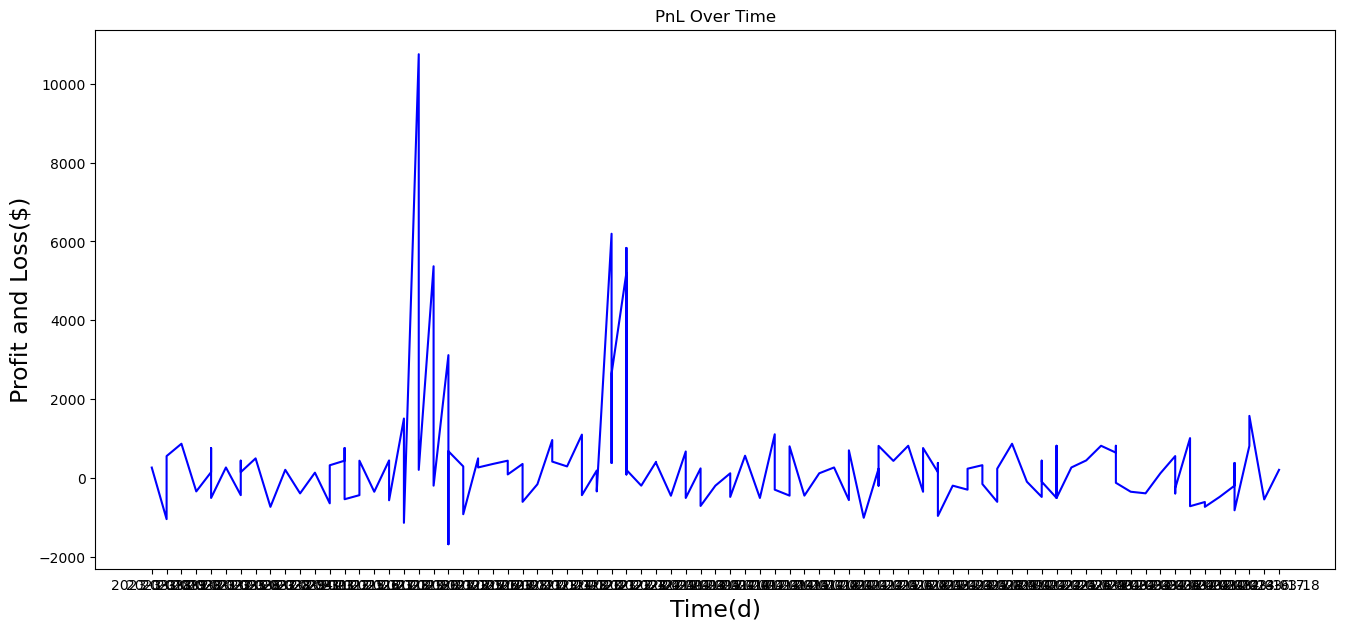

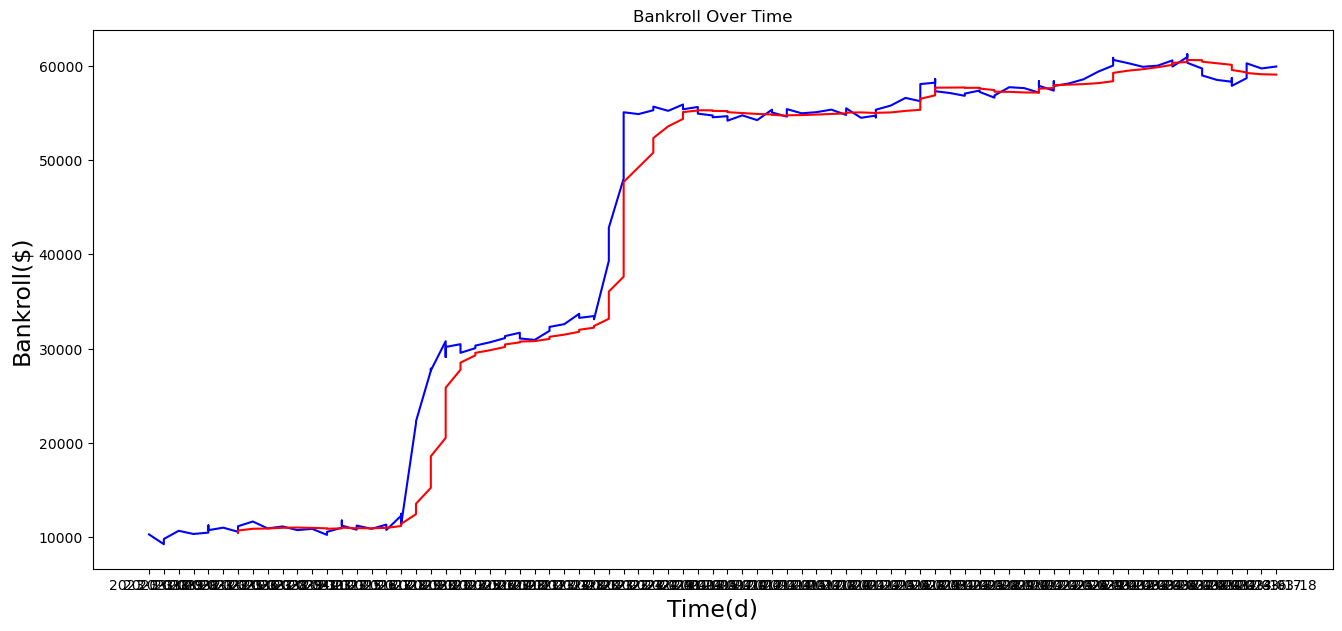



The position was held for 8 months, traded 156 times, and produced a return of 499.3965%.
The growth rate on each bet was 1.1545%.
The final balance is $59939.65.
The average of returns is 334.0803%.
The standard deviation of returns is 186.8393%.


The Sharpe Ratio of the strategy is 1.7881.


In [99]:
# best Calmar Ratio 
bet_very_undervalued = bet[bet['odds_diff'] > 0.02]
backtest(bet_very_undervalued, 10000, 0.5, 1.74)

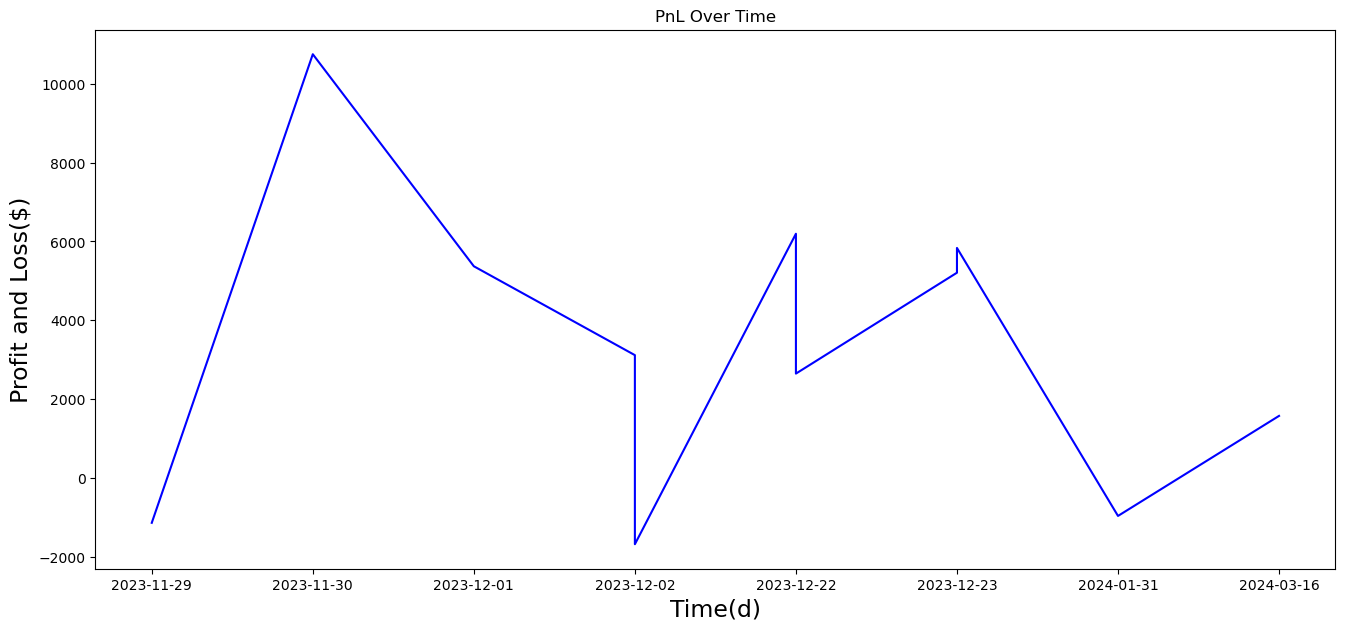

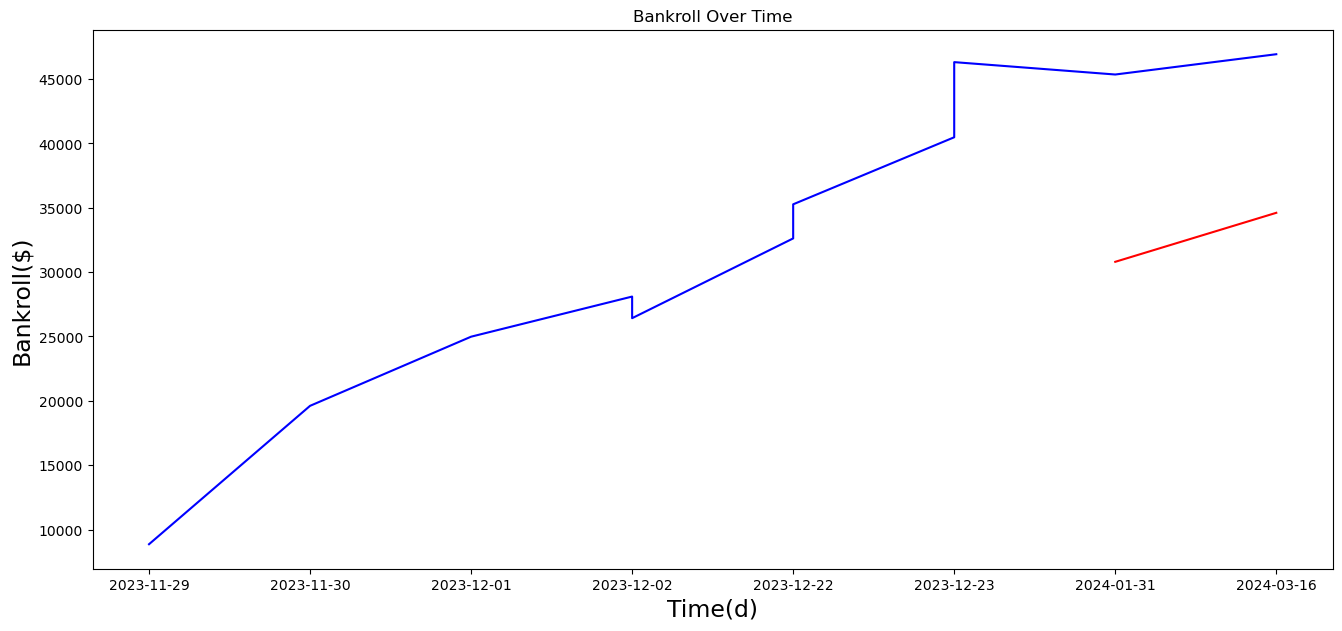



The position was held for 8 months, traded 11 times, and produced a return of 369.2711%.
The growth rate on each bet was 15.0902%.
The final balance is $46927.11.
The average of returns is 246.0784%.
The standard deviation of returns is 93.2603%.


The Sharpe Ratio of the strategy is 2.6386.


In [101]:
# best sharpe ratio
bet_very_undervalued = bet[bet['odds_diff'] > 0.41]
backtest(bet_very_undervalued, 10000, 0.5,  1.79)